In [1]:
import pandas as pd
import numpy as np
from boruta import BorutaPy 

In [2]:
from pycaret.classification import *

Let us first check for missing values:

In [3]:
#Read data
raw_data = pd.read_csv('employee_churn_data.csv')
#Check for missing values
raw_data.isna().sum()

department       0
promoted         0
review           0
projects         0
salary           0
tenure           0
satisfaction     0
bonus            0
avg_hrs_month    0
left             0
dtype: int64

In [4]:
raw_data.shape

(9540, 10)

As we can see, there are no missing values in the dataset.
Let's split the data into training and test set, and then perform analyses and modeling on the training set.

In [5]:
from sklearn.model_selection import train_test_split as tts
train, test = tts(raw_data,test_size=0.2,random_state=32)
train = pd.DataFrame(train,columns=raw_data.columns)
train.reset_index(level=None,inplace=True,drop=True)
test = pd.DataFrame(test,columns=raw_data.columns)
test.reset_index(level=None,inplace=True,drop=True)

In [83]:
test.to_csv('employee_churn_test.csv')

In [6]:
train.groupby('left').size()

left
no     5422
yes    2210
dtype: int64

In [7]:
train.groupby('promoted').size()

promoted
0    7395
1     237
dtype: int64

In [8]:
train.groupby('department').size()

department
IT              286
admin           340
engineering    1220
finance         323
logistics       297
marketing       647
operations     1204
retail         1225
sales          1490
support         600
dtype: int64

In [9]:
train.groupby('salary').size()

salary
high      1258
low       1106
medium    5268
dtype: int64

In [10]:
train.groupby('bonus').size()

bonus
0    6014
1    1618
dtype: int64

In [11]:
train[['review','projects','tenure','satisfaction','avg_hrs_month']].describe()

,review,projects,tenure,satisfaction,avg_hrs_month
count,7632.000000,7632.000000,7632.000000,7632.000000,7632.000000
mean,0.651366,3.276074,6.549528,0.505192,184.631365
std,0.085866,0.577537,1.421205,0.159187,4.163008
min,0.310000,2.000000,2.000000,0.000000,171.374060
25%,0.591343,3.000000,5.000000,0.386019,181.458141
50%,0.646676,3.000000,7.000000,0.502171,184.567823
75%,0.708208,4.000000,8.000000,0.624874,187.698120
max,1.000000,5.000000,12.000000,1.000000,200.861656


Let us produce boxplots to determine the spread of continuous variables' values.

{'whiskers': [<matplotlib.lines.Line2D at 0x272dda49e20>,
 'caps': [<matplotlib.lines.Line2D at 0x272dda67400>,
 'boxes': [<matplotlib.lines.Line2D at 0x272dda49b50>],
 'medians': [<matplotlib.lines.Line2D at 0x272dda679a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x272dda67c70>],
 'means': []}

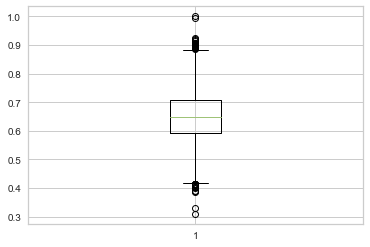

In [12]:
import matplotlib.pyplot as plt
#plt.figure
plt.boxplot(train['review'])

{'whiskers': [<matplotlib.lines.Line2D at 0x272ddb53460>,
 'caps': [<matplotlib.lines.Line2D at 0x272ddb53a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x272ddb53190>],
 'medians': [<matplotlib.lines.Line2D at 0x272ddb53fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x272ddb5f2b0>],
 'means': []}

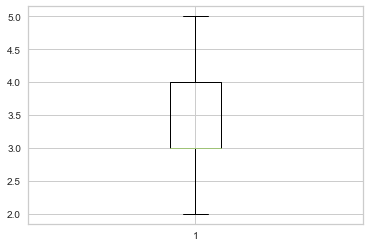

In [13]:
plt.boxplot(train['projects'])

{'whiskers': [<matplotlib.lines.Line2D at 0x272ddbbf2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x272ddbbf850>,
 'boxes': [<matplotlib.lines.Line2D at 0x272ddbb0fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x272ddbbfdf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x272ddbcd100>],
 'means': []}

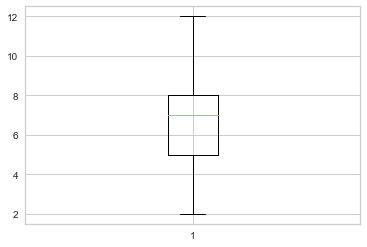

In [14]:
plt.boxplot(train['tenure'])

{'whiskers': [<matplotlib.lines.Line2D at 0x272ddc1c9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x272ddc1cf70>,
 'boxes': [<matplotlib.lines.Line2D at 0x272ddc1c700>],
 'medians': [<matplotlib.lines.Line2D at 0x272ddc2a550>],
 'fliers': [<matplotlib.lines.Line2D at 0x272ddc2a820>],
 'means': []}

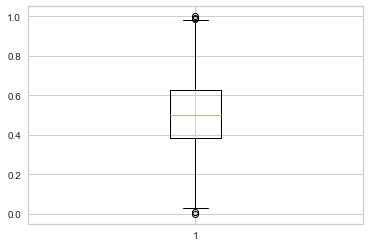

In [15]:
plt.boxplot(train['satisfaction'])

{'whiskers': [<matplotlib.lines.Line2D at 0x272ddc7db80>,
 'caps': [<matplotlib.lines.Line2D at 0x272ddc8d190>,
 'boxes': [<matplotlib.lines.Line2D at 0x272ddc7d8b0>],
 'medians': [<matplotlib.lines.Line2D at 0x272ddc8d730>],
 'fliers': [<matplotlib.lines.Line2D at 0x272ddc8da00>],
 'means': []}

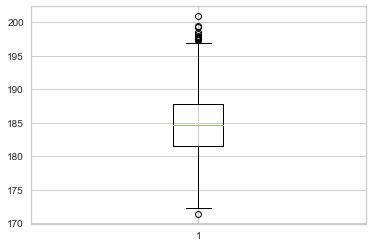

In [16]:
plt.boxplot(train['avg_hrs_month'])

Use the boruta method fo feature selection

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
boruta = BorutaPy(rf,n_estimators='auto',verbose=2, random_state=1)

In [34]:
#Preprocess data for boruta usage
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
train_copy = train.copy()
recode = {'yes':1,'no':0}
recode2 = {'low':1,'medium':2,'high':3}
train_copy['left'] = train_copy['left'].map(recode)
train_copy['salary'] = train_copy['salary'].map(recode2)
ct = ColumnTransformer([('deptonehot',OneHotEncoder(dtype=int),['department'])],
                       remainder='passthrough')
preprocessed_train = ct.fit_transform(train_copy)
ct.get_feature_names()

['deptonehot__x0_IT',
 'deptonehot__x0_admin',
 'deptonehot__x0_engineering',
 'deptonehot__x0_finance',
 'deptonehot__x0_logistics',
 'deptonehot__x0_marketing',
 'deptonehot__x0_operations',
 'deptonehot__x0_retail',
 'deptonehot__x0_sales',
 'deptonehot__x0_support',
 'promoted',
 'review',
 'projects',
 'salary',
 'tenure',
 'satisfaction',
 'bonus',
 'avg_hrs_month',
 'left']

In [35]:
target = train_copy['left'].values
boruta.fit(preprocessed_train[:,:18],target)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	14


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	14


BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=None, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=60, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x272E164FA40,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='

In [36]:
boruta.support_

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False,  True,  True, False,  True])

In [41]:
#print(train_copy.shape)
#print(preprocessed_train.shape)
print(ct.get_feature_names())

['deptonehot__x0_IT', 'deptonehot__x0_admin', 'deptonehot__x0_engineering', 'deptonehot__x0_finance', 'deptonehot__x0_logistics', 'deptonehot__x0_marketing', 'deptonehot__x0_operations', 'deptonehot__x0_retail', 'deptonehot__x0_sales', 'deptonehot__x0_support', 'promoted', 'review', 'projects', 'salary', 'tenure', 'satisfaction', 'bonus', 'avg_hrs_month', 'left']


Selected features are review, salary, tenure, satisfaction, and avg_hours_month.

Based on the box plots of these features shown earlier, some univariate outliers are present. Let us look for multivariate outliers using the (squared) Mahalanobis Distance and using a standard cut-off to find outliers and remove them. We will use the MCD estimate of robust covariance and robust mean as introduced by P.J.Rousseuw (1999), because the empirical estimates of covariance and mean are sensitive to outliers.

The squared Mahalanobis distance follows a chi-square distribution with the degrees of freedom being equal to the number of features used. The cut-off used will be the quantile corresponding to the 95th percentile.

In [42]:
#Get the features chosen by the boruta method
train_filtered = train[['review','tenure','satisfaction','avg_hrs_month','left']]

'''''''''
#Mahalanobis Distance
cov = np.cov(train_filtered.iloc[:,:4],rowvar=False)   #Covariance matrix
inv_covmat = np.linalg.inv(cov)                        #Inverse of covariance matrix
mean = np.mean(train_filtered.iloc[:,:4])
distances = []
for i, val in enumerate(train_filtered.iloc[:,:4].values):
    diff = val - mean  
    vector = diff.T
    left_term = np.dot(vector, inv_covmat) 
    distance_squared = np.dot(left_term, diff)
    distances.append(distance_squared)
distances = np.array(distances)
'''''''''
#Mahalanobis Distance using MCD
from sklearn.covariance import MinCovDet as MCD
cov = MCD(random_state=1).fit(X=train_filtered.iloc[:,:4])
distance = cov.mahalanobis(train_filtered.iloc[:,:4])

#Apply cutoff to find outliers
from scipy.stats import chi2
cutoff = chi2.ppf(0.95, train_filtered.iloc[:,:4].shape[1])
outlier_indexes = np.where(distance > cutoff)


In [43]:
print(cutoff)
print(max(distance))
print(outlier_indexes[0])
print(outlier_indexes[0].shape)

9.487729036781154
98.35935035793716
[   3    8   13 ... 7596 7598 7619]
(1007,)


1007 outliers have been detected. Let us remove these outliers and train a model.

In [44]:
outliers = outlier_indexes[0]
train_no_outliers = train_filtered.drop(outliers,axis=0)

In [45]:
print(train_filtered.shape)
print(train_no_outliers.shape)

(7632, 5)
(6625, 5)


In [46]:
s = setup(train_no_outliers,'left')

,Description,Value
0,session_id,4996
1,Target,left
2,Target Type,Binary
3,Label Encoded,"no: 0, yes: 1"
4,Original Data,"(6625, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [47]:
best = compare_models(sort='auc')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8538,0.9200,0.7040,0.7877,0.7423,0.6409,0.6438,0.0450
gbc,Gradient Boosting Classifier,0.8521,0.9132,0.6760,0.8003,0.7319,0.6310,0.6360,0.1840
rf,Random Forest Classifier,0.8471,0.9113,0.6933,0.7737,0.7305,0.6244,0.6268,0.2630
et,Extra Trees Classifier,0.8501,0.9105,0.7012,0.7780,0.7367,0.6325,0.6348,0.2290
knn,K Neighbors Classifier,0.8372,0.8791,0.6853,0.7509,0.7161,0.6024,0.6040,0.0290
ada,Ada Boost Classifier,0.7589,0.8265,0.4397,0.6456,0.5223,0.3689,0.3815,0.0990
qda,Quadratic Discriminant Analysis,0.7854,0.8243,0.4505,0.7303,0.5560,0.4255,0.4475,0.0130
dt,Decision Tree Classifier,0.8098,0.7740,0.6846,0.6828,0.6831,0.5473,0.5478,0.0150
lda,Linear Discriminant Analysis,0.7194,0.7109,0.2465,0.5782,0.3445,0.2016,0.2317,0.0100
lr,Logistic Regression,0.7119,0.7049,0.1258,0.5938,0.2064,0.1146,0.1665,0.0230


In [48]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

PyCaret gives the option to fine tune your selected model. Let us do so and compare with the original.

In [49]:
model = best
tuned_model = tune_model(model,optimize='auc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8621,0.9229,0.6691,0.8378,0.7440,0.6512,0.6589
1,0.8621,0.9220,0.7194,0.8000,0.7576,0.6616,0.6634
2,0.8448,0.9033,0.6691,0.7815,0.7209,0.6144,0.6179
3,0.8491,0.8996,0.6619,0.8000,0.7244,0.6218,0.6271
4,0.8513,0.9195,0.7194,0.7692,0.7435,0.6390,0.6397
5,0.8254,0.8967,0.6143,0.7611,0.6798,0.5617,0.5678
6,0.8664,0.9295,0.7857,0.7746,0.7801,0.6842,0.6842
7,0.8683,0.9184,0.7266,0.8145,0.7681,0.6765,0.6786
8,0.8553,0.9384,0.6978,0.7951,0.7433,0.6431,0.6458


In [50]:
print(model)
print(tuned_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4996, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
LGBMClassifier(bagging_fraction=0.7, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
               importance_type='split', learning_rate=0.2, max_depth=-1,
               min_child_samples=76, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=260, n_jobs=-1, num_leaves=60, objective=None,
               random_state=4996, reg_alpha=1, reg_lambda=0.7, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


Original model is better. Let's interpret it.

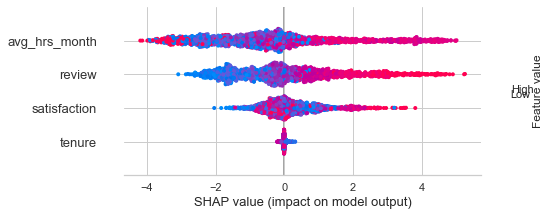

In [51]:
interpret_model(model)

Red dots represent higher values of the feature while blue dots represent lower values of the feature. 

The interpretation is that in general, the more hours an employee works on average, the higher the chance of churning. The lower the performance review rating, the less likely an employee will churn. For employee satisfaction, there is a small number of highly satisfied employees who ended up churning but generally there are more blue points on the right side of the graph, which mean that less satisfied employees are more likely to churn. Tenure relatively seems to have little impact on the outcome of predictions.

The findings on employee performance review ratings and satisfaction are interesting, where most employees with lower ratings tend to stay instead of churning. Findings like these warrant further review, perhaps relating to company culture and personal motivations of each employee. Same could be said about the findings with employee satisfaction.

Let's save the model.

In [52]:
save_model(model,'employee_churn_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='left',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strateg...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20,